# Random Forest

---

Aditya Marathe

## Imports and version

In [27]:
%matplotlib inline

import sys

import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt

**Local**:

In [10]:
sys.path.insert(1, './../')

import ana
import plotting
import transforms

**Version**:

In [3]:
print(f'Python {sys.version}\n')
print(f'NumPy {np.__version__}')

Python 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]

NumPy 1.26.4


## Configuration

In [11]:
config = {
    'Cuts': [
        'Detector Quality',
        'Data Quality',
        'Cosmic Rej.',
        'Veto'
    ],
    'Transforms': [
        transforms.tf_290124_positive_energies,
        transforms.tf_290124_valid_pid,
        transforms.tf_120224_first_prong
    ],
    'XCols': [
        'rec.sel.cvnloosepreselptp.cosmicid',
        'rec.sel.cvnloosepreselptp.ncid',
        'rec.sel.cvnloosepreselptp.numuid',
        'rec.sel.remid.pid',
        'rec.sel.scann.scpid'
    ],
    'YCols': [
        'ana.cat.event_type'
    ]
}

## Loading dataset

In [13]:
ds = Datasets()

Datasets | Found the following: MINI_DATA_DIR, DATA_V2_DIR, DATA_V3_DIR, REALLY_MINI_DIR, COPYMERGED_C6_DIR, COPYMERGED_C7_DIR, COPYMERGED_C8_DIR, COPYMERGED_C9_DIR, COPYMERGED_C10_DIR


In [14]:
data = ana.NOvAData.init_from_copymerge_h5(
    h5dirs=[
        # ds.COPYMERGED_C8_DIR,  # type: ignore
        # ds.COPYMERGED_C9_DIR,  # type: ignore
        ds.COPYMERGED_C10_DIR  # type: ignore
    ]
)

NOvAData | Loading tables from CM HDF5 files...
NOvAData | Loaded table from CM HDF5 files (1 / 1).
NOvAData | Initialised.


In [15]:
data.fill_ana_flags(inplace=True)
data.fill_ana_track_kinematics(inplace=True)
data.fill_categorical(inplace=True)

NOvAData | Filled MC truth flags.
NOvAData | Filled track kinematics.
NOvAData | Filled categorical data.


## Data prep.

In [16]:
cuts = ana.Cuts.init_nova_cuts()

In [18]:
# Cuts
for cut in config['Cuts']:
    data.table = cuts.apply_cut(cut, data.table)

Cuts     | Applied 'Detector Quality' cut (184_661 -> 155_060 events).
Cuts     | Applied 'Data Quality' cut (155_060 -> 155_056 events).
Cuts     | Applied 'Cosmic Rej.' cut (155_056 -> 58_303 events).
Cuts     | Applied 'Veto' cut (58_303 -> 53_073 events).


In [20]:
# Transforms
for tf in config['Transforms']:
    data.table = tf(df=data.table)


In [44]:
interesting_vars = [
	'rec.energy.numu.calccE',
	'rec.energy.numu.hadcalE',
	'rec.energy.numu.hadtrkE',
	'rec.energy.numu.lstmmuon',
	'rec.energy.numu.lstmnu',
	'rec.energy.numu.regcvnhadE',
	'rec.energy.numu.trkccE',
	'rec.energy.numu.recomuonE',
	'rec.energy.numu.hadclust.calE',
	'rec.energy.numu.hadclust.nhit',
	'rec.sel.contain.kalfwdcell',
	'rec.sel.contain.kalbakcell',
	'rec.sel.contain.cosfwdcell',
	'rec.sel.contain.cosbakcell',
	'rec.sel.cosrej.numucontpid2020fhc',
	'rec.sel.cvnloosepreselptp.cosmicid',
	'rec.sel.cvnloosepreselptp.ncid',
	'rec.sel.cvnloosepreselptp.nueid',
	'rec.sel.cvnloosepreselptp.numuid',
	'rec.sel.remid.pid',
	'rec.sel.scann.scpid',
	'rec.slc.calE',
	'rec.slc.firstplane',
	'rec.slc.lastplane',
	'rec.slc.nhit',
	'rec.slc.ncontplanes',
	'rec.trk.kalman.ntracks',
	'rec.trk.kalman.ntracks2d',
	'ana.trk.kalman.tracks.cosBeam', 
	'ana.trk.kalman.tracks.PtToPmu',
	'ana.trk.kalman.tracks.Pmu', 
	'ana.trk.kalman.tracks.Pt',
    # 'ana.cut.flag.cvn_pid',
    # 'ana.cut.flag.containment',
]

print('Number of interesting vars = ', len(interesting_vars))

Number of interesting vars =  32


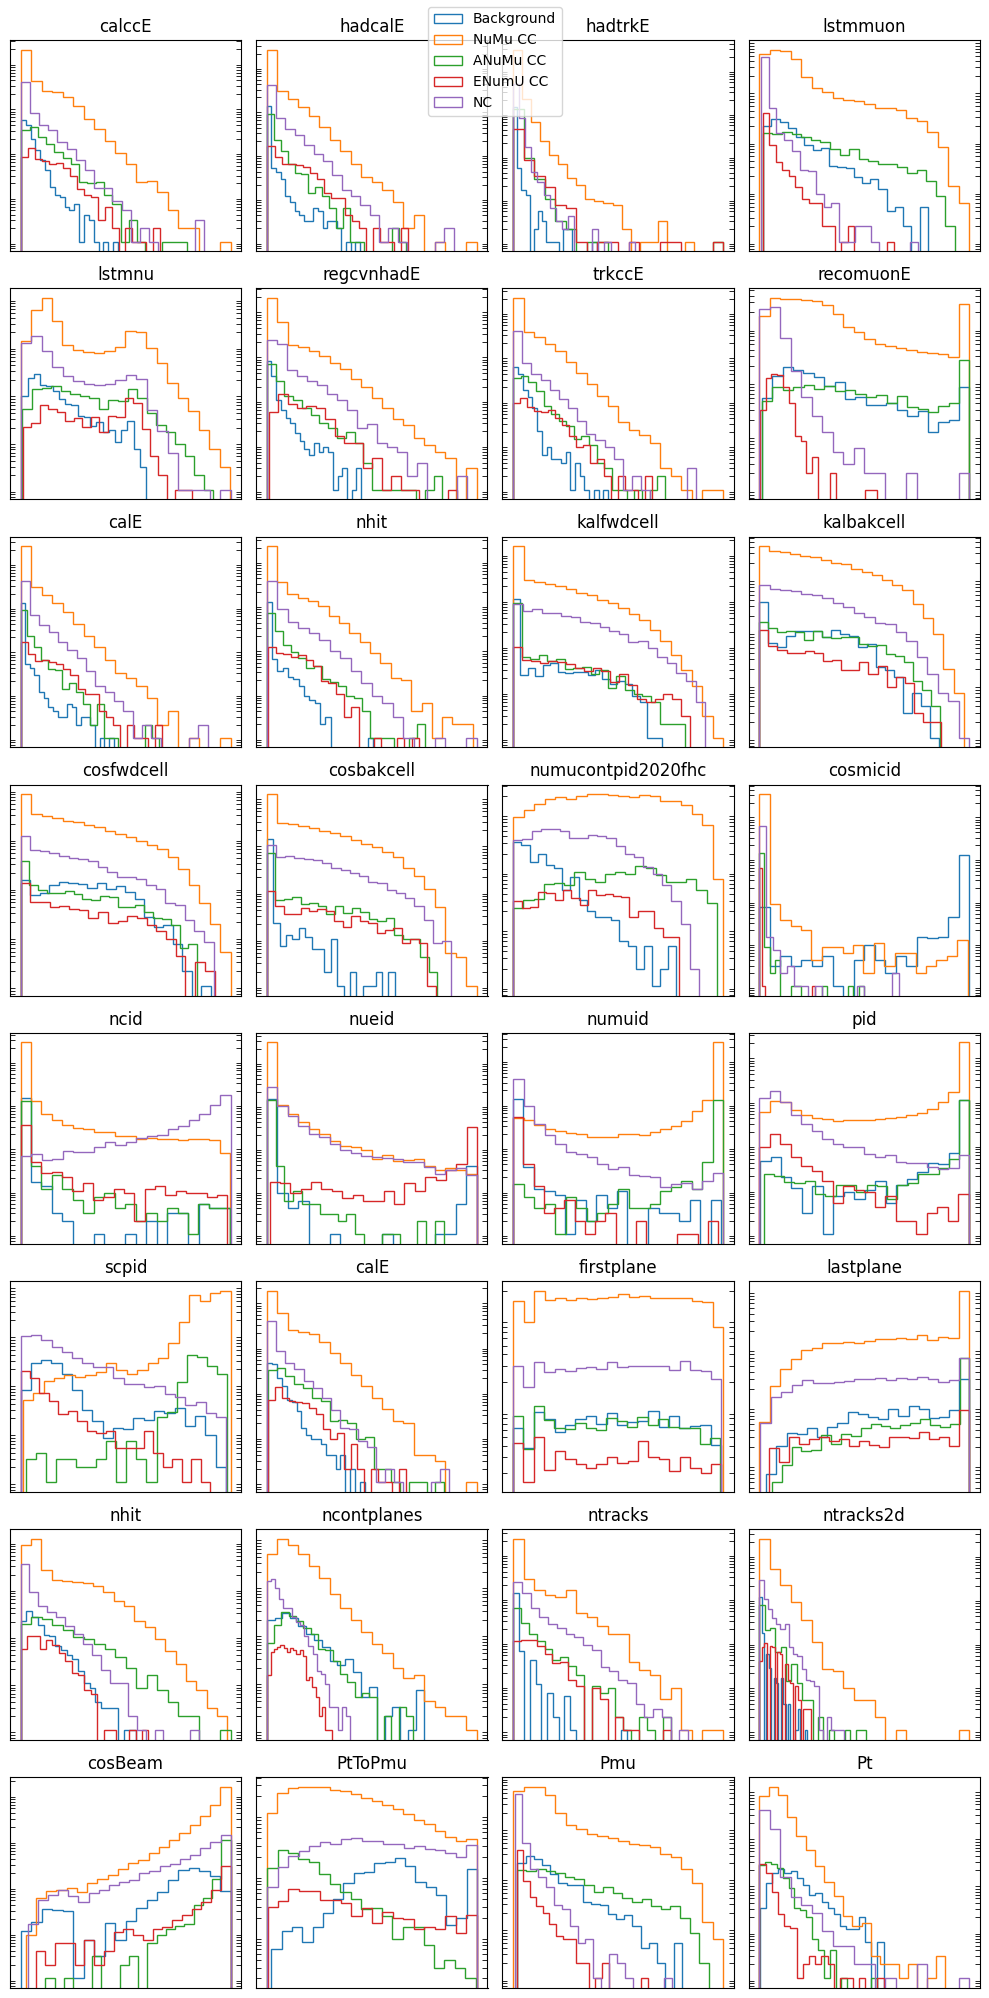

In [50]:
subplots = plotting.Subplots(8, 4, figsize=(10, 20))

for i, var in enumerate(interesting_vars):
    ax = subplots.axs[i]

    for id_, name in ana.EVENT_TYPE_MAP.items():
        *_, poly = ax.hist(
            data.table[data.table['ana.cat.event_type'] == id_][var],
            bins=20,
            label=name,
            histtype='step'
        )

    handles, labels = ax.get_legend_handles_labels()

    ax.set_yscale('log')

    ax.set_xticks([])
    ax.set_yticks([])

    ax.set_title(var.split('.')[-1])

subplots.fig.legend(handles=handles, labels=labels, loc='upper center')

plt.tight_layout();

In [57]:
tt_split = data.train_test_split(
    x_cols=config['XCols'],
    y_cols=config['YCols'],
    test_size=0.3
)

tt_split['YTrain'] = tt_split['YTrain'].to_numpy().flatten()

NOvAData | Initialised.


array([1., 1., 4., ..., 1., 1., 1.])

In [29]:
ss = StandardScaler()
# x_table.loc[:, scale_vars] = ss.fit_transform(x_table[scale_vars])

## Random Forest

In [51]:
rf = RandomForestClassifier()
rf.fit(tt_split['XTrain'], tt_split['YTrain'])

c:\Users\Shrey\OneDrive\Documents\GitHub\msci-project\.venv\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


KeyboardInterrupt: 

In [80]:
prediction = rf.predict(x_test_table)

In [81]:
y_test_table

0        1.0
1        1.0
2        1.0
3        1.0
4        1.0
        ... 
12216    1.0
12217    1.0
12218    1.0
12219    1.0
12220    1.0
Name: EventType, Length: 12221, dtype: float64

In [82]:
prediction

array([1., 1., 1., ..., 1., 1., 1.])

In [83]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay

In [84]:
y_test_table.value_counts()

EventType
1.0    9530
4.0    1678
0.0     428
2.0     424
3.0     161
Name: count, dtype: int64

In [85]:
9530 + 424

9954

In [86]:
(9530 + 424) / len(y_test_table)

0.81449963178136

In [87]:
pd.Series(prediction).value_counts()

1.0    9935
4.0    1739
0.0     411
3.0     135
2.0       1
Name: count, dtype: int64

In [89]:
(9935 + 1) / len(prediction)

0.8130267572211767

In [71]:
accuracy_score(
    y_pred=(prediction == 1) * 1. + (prediction == 2) * 1., 
    y_true=(y_test_table == 1) * 1. + (y_test_table == 2) * 1.
)

0.9486948694869487

In [72]:
precision_score(
    y_pred=(prediction == 1) * 1. + (prediction == 2) * 1., 
    y_true=(y_test_table == 1) * 1. + (y_test_table == 2) * 1.
)

0.9704428528195299

In [73]:
recall_score(
    y_pred=(prediction == 1) * 1. + (prediction == 2) * 1., 
    y_true=(y_test_table == 1) * 1. + (y_test_table == 2) * 1.
)

0.9664456499899537

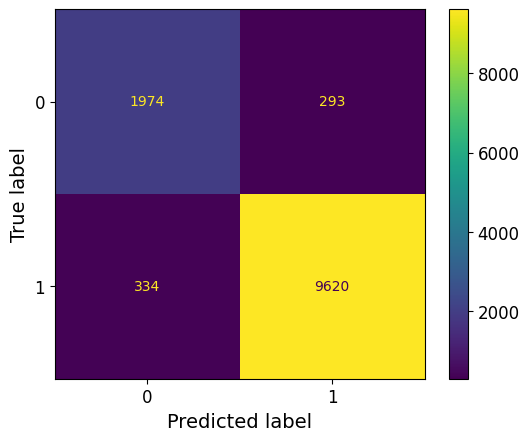

In [74]:
cm = confusion_matrix(
    y_true=(y_test_table == 1) * 1. + (y_test_table == 2) * 1., 
    y_pred=(prediction == 1) * 1. + (prediction == 2) * 1.
)

# TP, FP
# FN, TN

ConfusionMatrixDisplay(cm).plot();

In [75]:
((y_test_table == 1) * 1. + (y_test_table == 2) * 1. == (prediction == 1) * 1. + (prediction == 2) * 1.).value_counts()

EventType
True     11594
False      627
Name: count, dtype: int64

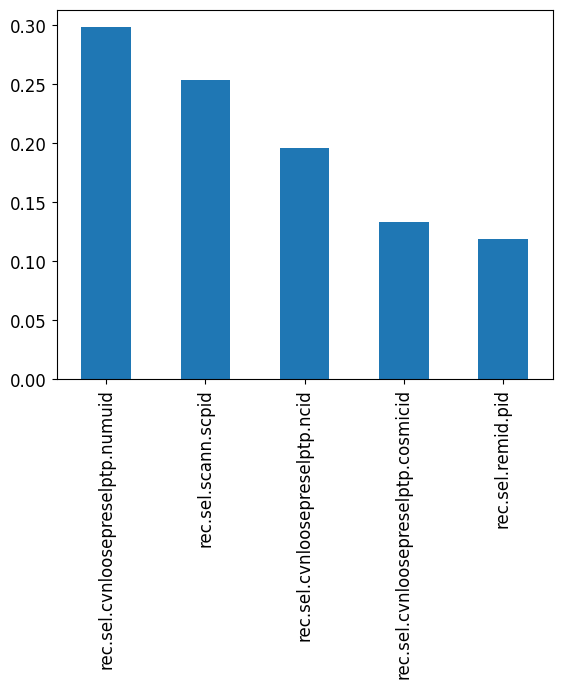

In [76]:
feature_importances = pd.Series(rf.feature_importances_, index=x_train_table.columns).sort_values(ascending=False)
feature_importances.plot.bar();